## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px
import plotly.graph_objs as go

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [4]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [6]:
data['date'] = pd.to_datetime(data['date'])
group_A = data[data['group'] == 'A']
group_B = data[data['group'] == 'B']
# берём к примеру группу B, также можно и с A 
display(group_B['date'].min())
display(group_B['date'].max())  # также  можно сделать с помощью метода groupby() и sort_values()
display(data.groupby('group')['date'].agg(['min', 'max']))

Timestamp('2021-01-02 00:00:00')

Timestamp('2021-01-24 00:00:00')

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [7]:
data_counter = data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price' : 'sum'
}).reset_index().rename(
    columns={'user_id':'user_count',
             'purchase':'purchase_count',
             'price': 'price_sum'})
data_counter


,group,user_count,purchase_count,price_sum
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [8]:
group_a =  set(data[data['group'] == 'A']['user_id'])
group_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = group_a.intersection(group_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [9]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

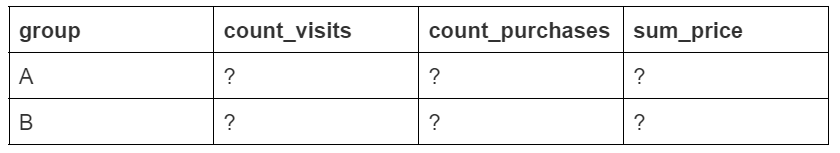
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [10]:
# вставляем переменную для исключения пользователей updated_data 
data_analysis = updated_data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price' : 'sum'
}).reset_index().rename(
    columns={'user_id':'count_visits',
             'purchase':'count_purchases',
             'price': 'sum_price'})
data_analysis  # делаем также как в задании 7.3

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Из представленных данных можно сделать следующие выводы:

Общее количество посещений на обеих страницах примерно одинаково (145307 в группе A и 145381 в группе B), 
что говорит о том, что выборки могут быть сбалансированы.


## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [11]:
data_analysis['conversion'] = (data_analysis['count_purchases'] / data_analysis['count_visits']) * 100
data_analysis['mean_check'] = (data_analysis['sum_price'] / data_analysis['count_purchases'])
display(round(data_analysis['conversion'], 2))
display(round(data_analysis['mean_check']))
data_analysis

0    12.03
1    11.89
Name: conversion, dtype: float64

0    81076.0
1    88665.0
Name: mean_check, dtype: float64

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Основываясь на этих показателях, мы можем сделать вывод, что группа A более эффективна с точки зрения коэффициента конверсии, в то время как группа B более эффективна с точки зрения среднего чека. Однако важно отметить, что необходим дальнейший анализ для определения статистической значимости этих различий и выявления потенциальных факторов, которые могут повлиять на результаты.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [12]:

pivot_data = updated_data.pivot_table(
    index='group',
    columns='price',
    values='purchase',
    aggfunc='sum'
)
pivot_data


price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


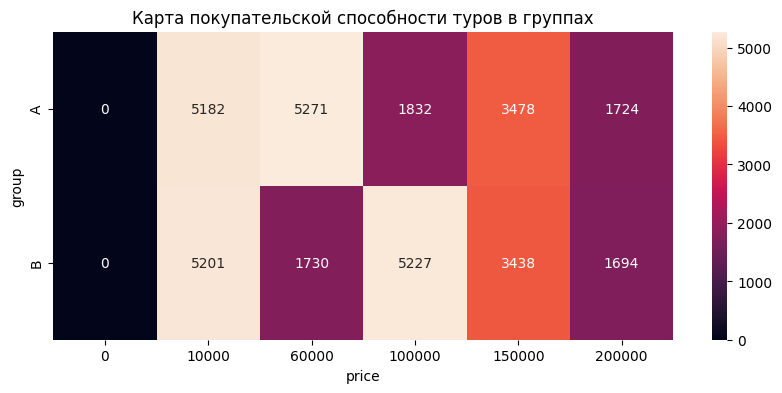

In [13]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot_data, annot=True, fmt='g')
ax.set_title('Карта покупательской способности туров в группах')  
# Display the plot
plt.show()


In [14]:
# дополнительно используя plotly

fig = go.Figure(
    go.Heatmap(
        z=pivot_data.values,
        x=pivot_data.columns,
        y=pivot_data.index,
        colorscale='Viridis')
)


fig.update_layout(
    title='Карта покупательской способности туров в группах',
    xaxis_title='Price',
    yaxis_title='Group'
)

# Show plot
fig.show()

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Мы видим, что туры за 10000 тысяч рублей незначительно больше в группе B, чем в A (почти одинаковое количество). 
Туры за 60000 тысяч больше покупают из группы А по сравнению с группой B. 
Абсолютно противоположную ситуацию наблюдаем с турами за 100 тыс.
Остальные туры находятся +- на одинаковом уровне, одинаковый цвет это подтверждает  

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
daily_A_B = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
    
    
}).reset_index()
daily_A_B['daily_conversion'] = (daily_A_B['purchase'] / daily_A_B['user_id']) *100
daily_A_B['daily_mean_check'] = daily_A_B['price'] / daily_A_B['purchase']


print(round(daily_A_B[(daily_A_B['date'] == '2021-01-03') & (daily_A_B['group'])
]['daily_conversion'], 2)) # ежедневная конверсия
print(round(daily_A_B[daily_A_B['date'] == '2021-01-03']['daily_mean_check'])) # ежедневный средний чек 

2    11.34
3    11.39
Name: daily_conversion, dtype: float64
2    82888.0
3    87480.0
Name: daily_mean_check, dtype: float64


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [16]:
daily_A_B.head(5)

,date,group,user_id,purchase,price,daily_conversion,daily_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


In [17]:
daily_A_B['cum_user_id'] = daily_A_B.groupby(['group'])['user_id'].cumsum() # кумулятивное посещение страницы
daily_A_B['cum_purchase_count'] = daily_A_B.groupby(['group'])['purchase'].cumsum() # кумулятивное количество покупок
daily_A_B['cum_price_sum'] = daily_A_B.groupby(['group'])['price'].cumsum() # кумулятивная сумма покупок

daily_A_B['cum_conversion'] = (daily_A_B['cum_purchase_count'] / daily_A_B['cum_user_id']) * 100
daily_A_B['cum_check'] = daily_A_B['cum_price_sum'] / daily_A_B['cum_purchase_count']

print(round(daily_A_B[(daily_A_B['date'] == '2021-01-20') & (daily_A_B['group'] == 'B')
]['cum_conversion'], 2)) #кумулятивная конверсия для группы B

print(round(daily_A_B[(daily_A_B['date'] == '2021-01-12') & (daily_A_B['group'] == 'A')]['cum_check']))
# кумулятивный средний чек для группы A

37    11.9
Name: cum_conversion, dtype: float64
20    81492.0
Name: cum_check, dtype: float64


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

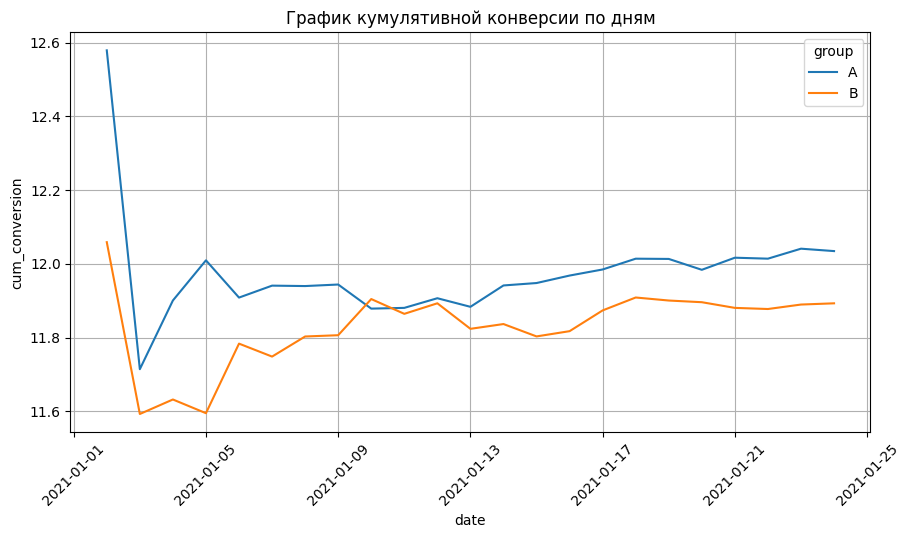

In [18]:
# График кумулятивной конверсии по дням
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_A_B,
    x='date',
    y='cum_conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

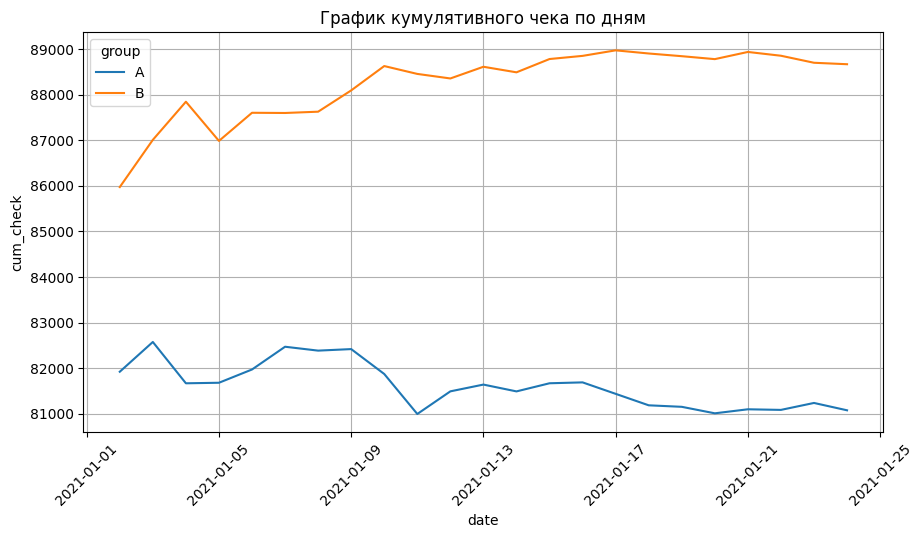

In [19]:
# Создаём кумулятивный график среднего чека 
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_A_B,
    x='date',
    y='cum_check',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График кумулятивного чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Вывод: на данных графиках мы видим что данные стабилизировались, на графике кумулятивной конверсии мы можем наблюдать что в среднем почти всегда чуть выше результаты в группе A. 
На втором графике мы можем наблюдать что показатели кумулятивного среднего чека выше в группе B(также мы наблюдаем восходящий тренд, по сравнению с группой А)

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [20]:

z_analysis = data.groupby('group')['purchase'].agg(['sum', 'count']).reset_index()

H0 = 'Конверсии в группах A и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'

alpha = 0.05

# Вычисляем статистику z и p-value
count = z_analysis['sum']
nobs = z_analysis['count']
zstat, pval = proportions_ztest(count=count, nobs=nobs, alternative='smaller', value=0)

# Проверяем гипотезу
if pval < alpha:
    print(f"Отвергаем нулевую гипотезу H0 {H0}")
    print(f"Альтернативная гипотеза. H1:{H1}")
else:
    print(f"Принимаем нулевую гипотезу {H0}")

Принимаем нулевую гипотезу Конверсии в группах A и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Мы Принимаем нулевую гипотезу Конверсии в группах A и B равны

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [21]:
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

conversion_a = (a_data['purchase'].sum() / a_data['user_id'].count()) * 100 
conversion_b = (b_data['purchase'].sum() / b_data['user_id'].count()) * 100


In [22]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [23]:
from scipy.stats import norm
# доверительный признак 

conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)

conf_interval_b = conversion_conf_interval(
    b_data['user_id'].count(), # размер выборки
    b_data['purchase'].mean() # выборочная пропорция 
)
print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.21)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [24]:
# Доверительный интервал для разницы конверсии в группах:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [25]:
# Доверительный интервал для разницы конверсии в группах:
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print(f'Доверительный интервал для разности конверсий: {diff_inverval}')


Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [26]:

conversion_piv = data.groupby('group')['purchase'].agg(
    ['mean', 'median']
)
display(conversion_piv) # сравниваем среднее и медианное значение purchase в обеих группах 

,mean,median
group,,
A,0.120399,0.0
B,0.118920,0.0


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительный интервал для разности конверсий между группами (-0.38, 0.09) также подтверждает, что статистически значимой разницы между конверсиями в группах А и B нет, так как интервал содержит нулевое значение. Однако важно отметить, что при таком доверительном интервале в  (95%) статистическое замечание может быть не очень точным.

Таким образом, на основании построенных доверительных интервалов мы можем предположить, что в целом конверсии в группах А и B не сильно отличаются друг от друга, но это могут подтвердить только более точные статистические методы анализа.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [40]:
daily_A_B.head()

,date,group,user_id,purchase,price,daily_conversion,daily_mean_check,cum_user_id,cum_purchase_count,cum_price_sum,cum_conversion,cum_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


In [46]:
shapiro_result_a = daily_A_B[daily_A_B['group'] == 'A']
shapiro_result_b = daily_A_B[daily_A_B['group'] == 'B']

H0 = 'Распределение нормальное'
H1 = 'Распределение отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(shapiro_result_a['daily_mean_check'])
shapiro_result_b = shapiro(shapiro_result_b['daily_mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [68]:

ttest_a = daily_A_B[daily_A_B['group'] == 'A']
ttest_b = daily_A_B[daily_A_B['group'] == 'B']

H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=ttest_a['daily_mean_check'],
    b=ttest_b['daily_mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


In [66]:
ttest_a['daily_mean_check'].mean() # вспомогательно

80969.2850990052

In [67]:
ttest_b['daily_mean_check'].mean() # вспомогательно

88575.71551361024

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Как мы видим из результатов: Ежедневный средний чек в группе А меньше чем в группе B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [94]:
def tt_conversion_conf_interval(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)

In [95]:
ttest_a = daily_A_B[daily_A_B['group'] == 'A']
ttest_b = daily_A_B[daily_A_B['group'] == 'B']
ttest_a.head()

,date,group,user_id,purchase,price,daily_conversion,daily_mean_check,cum_user_id,cum_purchase_count,cum_price_sum,cum_conversion,cum_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266


In [99]:
conf_interval_a = tt_conversion_conf_interval(
ttest_a['user_id'].count(), # размер выборки
ttest_a['daily_mean_check'].mean(), # выборочная пропорция
x_std=ttest_a['daily_mean_check'].std()
)

conf_interval_b = tt_conversion_conf_interval(
    ttest_b['user_id'].count(), # размер выборки
    ttest_b['daily_mean_check'].mean(), # выборочная пропорция
    x_std=ttest_b['daily_mean_check'].std()
)
print(f'Доверительный интервал для среднего чека группы А: {conf_interval_a}')
print(f'Доверительный интервал для среднего чека группы B: {conf_interval_b}')

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительный интервал для среднего чека группы А: (79630, 82308) и группы В: (87626, 89526) не пересекаются, это означает что в группах присутствуют статистически значимые различия между средними чеками.

## **Сделайте общий вывод по результатам A/B-теста**

Основываясь на результатах мы можем сказать, что лучше всего использовать 2 вариант дизайна посадочной страницы, так как средний чек у нас оказался выше, конверсии в обеих группах почти одинаковые. 